### **WIP, still trying to determine why the CDF estimates don't match ESPN's website. prior to that, I can't confirm I'm getting the same distributions that are made available by ESPN

# analyze watson projection data
ref http://ben-tanen.com/projects/2020/01/08/ibm-watson-ff.html (ppr)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
w = pd.read_csv('ibm-watson-ff-projections-2019.csv')
w.head()

,player,week,actual_score,proj_score,boom_pct,boom_pts,bust_pct,bust_pts,mid_pct
0,49ers D/ST,Week 01 vs Bucs,28.0,6.3,0.24,12.6,0.10,4.3,0.66
1,49ers D/ST,Week 02 vs Bengals,7.0,6.1,0.23,15.3,0.08,4.1,0.69
2,49ers D/ST,Week 03 vs Steelers,8.0,7.4,0.23,13.0,0.19,4.3,0.58
3,49ers D/ST,Week 05 vs Browns,19.0,6.0,0.14,14.7,0.21,3.7,0.65
4,49ers D/ST,Week 06 vs Rams,12.0,6.0,0.23,14.6,0.14,4.1,0.63


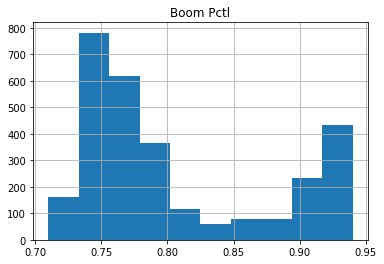

In [11]:
(1 - w.boom_pct).hist()
plt.title('Boom Pctl')
plt.show()

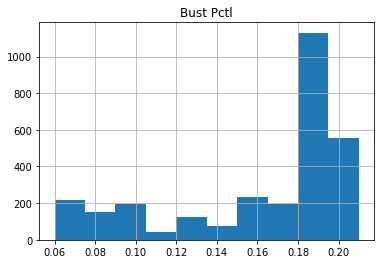

In [12]:
w.bust_pct.hist()
plt.title('Bust Pctl')
plt.show()

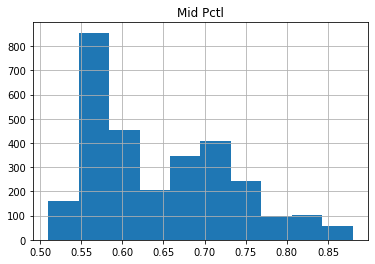

In [13]:
w.mid_pct.hist()
plt.title('Mid Pctl')
plt.show()

In [14]:
import requests

here is a link to access josh jacob's watson distribution data. let's test it out to make sure the distribution looks correct!
https://watsonfantasyfootball.espn.com/espnpartner/dallas/players/players_4047365_ESPNFantasyFootball_2020.json
https://watsonfantasyfootball.espn.com/espnpartner/dallas/projections/projections_4047365_ESPNFantasyFootball_2020.json

In [15]:

pid = 3916387
resp = json.loads(requests.get('https://watsonfantasyfootball.espn.com/espnpartner/dallas/projections/projections_{}_ESPNFantasyFootball_2020.json'.format(pid)).text)
len(resp)

79

In [17]:
rec = resp[-1]

In [18]:
import datetime

def parse_date(data_timestamp):
    return datetime.datetime.strptime(data_timestamp[:10], '%Y-%m-%d').date()

parse_date(rec['DATA_TIMESTAMP'])

datetime.date(2020, 12, 16)

In [19]:
def get_week_dates(week_dt):
    return [week_dt + datetime.timedelta(days=-d) for d in range(3,-3,-1)]

def get_all_week_dates(last_sunday, first_sunday=datetime.date(2020,9,13)):
    dt = first_sunday
    dts = {}
    i = 1
    while dt <= last_sunday:
        dts[i] = get_week_dates(dt)
        dt = dt + datetime.timedelta(days=7)
        i += 1
    return dts

last_sunday = [datetime.date.today() + datetime.timedelta(days=-d) for d in range(7) if (datetime.date.today() + datetime.timedelta(days=-d)).isoweekday() == 7][-1]
all_wk_dts = get_all_week_dates(last_sunday)
all_wk_dts[1], all_wk_dts[14]

([datetime.date(2020, 9, 10),
  datetime.date(2020, 9, 11),
  datetime.date(2020, 9, 12),
  datetime.date(2020, 9, 13),
  datetime.date(2020, 9, 14),
  datetime.date(2020, 9, 15)],
 [datetime.date(2020, 12, 10),
  datetime.date(2020, 12, 11),
  datetime.date(2020, 12, 12),
  datetime.date(2020, 12, 13),
  datetime.date(2020, 12, 14),
  datetime.date(2020, 12, 15)])

In [20]:
def find_wk_num(dt_str, all_wk_dts):
    for k, v in all_wk_dts.items():
        if parse_date(dt_str) in v:
            return k
        
find_wk_num(rec['DATA_TIMESTAMP'], all_wk_dts)

In [21]:
len(json.loads(rec['SCORE_DISTRIBUTION']))

1000

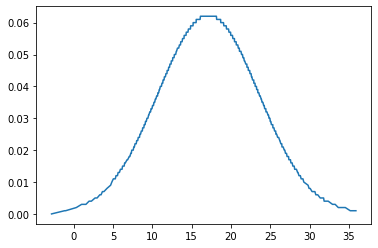

In [22]:
import numpy as np

dist = np.array(json.loads(rec['SCORE_DISTRIBUTION']))
dist[:, 0]
plt.plot(dist[:, 0], dist[:, 1])
plt.show()

In [23]:
def find_nearest_argmin(array, value):
    array = np.array(array)
    idx = (np.abs(array - value)).argmin()
    return idx

end_idx = find_nearest_argmin(dist[:, 0], rec['LOW_SCORE'])
mid_idx = find_nearest_argmin(dist[:, 0], rec['SIMULATION_PROJECTION'])
start_idx = find_nearest_argmin(dist[:, 0], rec['HIGH_SCORE'])
dist[:end_idx, 1].sum() / dist[:, 1].sum(), dist[:mid_idx, 1].sum() / dist[:, 1].sum(), dist[start_idx:, 1].sum() / dist[:, 1].sum()

(0.06929848820058995, 0.4593703908554572, 0.0838633849557522)

In [24]:
dist[:, 1].sum()

43.39200000000001

In [25]:
rec

{'PLAYERID': '3916387',
 'EVENT_NAME': 'ESPNFantasyFootball',
 'EVENT_YEAR': '2020',
 'DATA_TIMESTAMP': '2020-12-16 00:00:00.000000',
 'MODEL_NAME': 'qb_point.pkl',
 'MODEL_TYPE': 'qb_point_projection',
 'EXECUTION_TIMESTAMP': '2020-12-15 10:47:01.000000',
 'POLYNOMIAL_DEGREE': 1,
 'SCORE_PROJECTION': 19.631184393210724,
 'SCORE_DISTRIBUTION': '[[-2.8158699631825534, 0.0], [-1.16107137145492, 0.001], [-1.0242811512209613, 0.001], [0.3343753116127175, 0.002], [1.0059537976933406, 0.003], [1.1438739559172042, 0.003], [1.1624991148195818, 0.003], [1.2582655718510676, 0.003], [1.2880394711462184, 0.003], [1.3310958817734146, 0.003], [1.553320502857252, 0.003], [1.9548509186941505, 0.004], [2.2514578277897623, 0.004], [2.715962384087332, 0.005], [2.834325557833818, 0.005], [2.9780289361680445, 0.005], [3.3197703835794083, 0.006], [3.4007983822663572, 0.006], [3.412930916619299, 0.006], [3.4224281714412896, 0.006], [3.459539995177453, 0.006], [3.480421236311111, 0.006], [3.65094986744662, 0.

In [27]:
json.loads(rec['SCORE_DISTRIBUTION'])[:3]

[[-2.8158699631825534, 0.0],
 [-1.16107137145492, 0.001],
 [-1.0242811512209613, 0.001]]

ideas for what to do with the distributions:
- copy model calibration analysis: http://ben-tanen.com/projects/2020/01/08/ibm-watson-ff.html
- compute the percentile of each of the estimates according to the distributions and see if it follows a normal distribution
  - compute into buckets of n=2,5,10, and 100 and plot as a histogram
  - do a permutation test against samples from a normal distributions (0, 100) to see if the percentiles come from a uniform distribuion in a way that is statistically significant